In [1]:
import torch
mps_device = torch.device("mps")

In [2]:
import pathlib
import io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

# import keras
from keras import layers
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import AUC
from tensorflow.image import resize

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings (1=INFO, 2=WARNING, 3=ERROR)

2025-04-13 00:52:00.400854: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load Data and Create Datasets

In [7]:
def load_data():
    # Dataset/hyperparams
    sandbox_dir = pathlib.Path("../Data/Weather_Dataset")
    batch_size = 8
    image_size = (224, 224)  # do not change for resnet50

    # Load dataset
    dataset = tf.keras.utils.image_dataset_from_directory(
        sandbox_dir,
        labels='inferred',
        label_mode='int',
        validation_split=0.2,
        subset="both",
        seed=1234,
        batch_size=batch_size,
        image_size=image_size,
        shuffle=True
    )

    ### USE THESE 
    train_dataset, val_dataset = dataset  

    # === Oversampling Preprocessing for the Training Dataset ===
    # Unbatch the training dataset to work with individual samples
    train_ds_unbatched = train_dataset.unbatch()

    # Retrieve class names and determine number of classes
    class_names = train_dataset.class_names
    num_classes = len(class_names)

    # Create a separate dataset for each class using filtering
    class_datasets = {}
    for i in range(num_classes):
        # Filter out samples that belong to class i
        class_datasets[i] = train_ds_unbatched.filter(lambda image, label: label == i)

    # Count samples per class
    counts = {}
    for i in range(num_classes):
        counts[i] = class_datasets[i].reduce(0, lambda x, _: x + 1).numpy()
    print("Original class counts:", counts)

    # Determine the maximum count among all classes
    max_count = max(counts.values())

    # Oversample each class: repeat and take exactly max_count samples for each
    oversampled_datasets = []
    for i in range(num_classes):
        ds = class_datasets[i].repeat().take(max_count)
        oversampled_datasets.append(ds)

    # Combine the oversampled datasets into one balanced dataset
    balanced_train_ds = oversampled_datasets[0]
    for ds in oversampled_datasets[1:]:
        balanced_train_ds = balanced_train_ds.concatenate(ds)

    # Shuffle and batch the balanced training dataset
    balanced_train_ds = balanced_train_ds.shuffle(buffer_size=1000).batch(batch_size)

    # Optionally, replace train_dataset with the balanced version
    train_dataset = balanced_train_ds

    # === Display a few samples from the balanced training dataset ===
    for images, labels in train_dataset.take(1):
        fig, axes = plt.subplots(1, 5, figsize=(15, 5))
        for i in range(5):
            axes[i].imshow(images[i].numpy().astype("uint8"))
            axes[i].axis("off")
            axes[i].set_title(f"Label: {labels[i].numpy()}")
        plt.show()
        break

    return train_dataset, val_dataset

In [8]:
def create_datasets(train_dataset, val_dataset):
    # Get X_val and y_val, normalize
    X_train, y_train = [], []
    for images, labels in train_dataset:
        X_train.append((images.numpy() / 255.0))
        y_train.append(labels.numpy())
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)

    X_val, y_val = [], []
    for images, labels in val_dataset:
        X_val.append((images.numpy() / 255.0))
        y_val.append(labels.numpy())
    X_val = np.concatenate(X_val, axis=0)
    y_val = np.concatenate(y_val, axis=0)

    y_train = y_train.reshape(y_train.shape[0], 1)
    y_val = y_val.reshape(y_val.shape[0], 1)

    return X_train, y_train, X_val, y_val

Found 6862 files belonging to 11 classes.
Using 5490 files for training.
Using 1372 files for validation.


2025-04-13 00:52:54.927780: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-13 00:52:56.272470: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-13 00:52:57.201597: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-13 00:52:59.595898: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-13 00:53:00.398476: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-13 00:53:01.207118: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-13 00:53:02.897997: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-13 00:53:03.672024: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-13 00:53:04.616862: W tensorflow/core/lib/png/png_io.cc:89] PNG 

Original class counts: {0: 559, 1: 678, 2: 379, 3: 514, 4: 485, 5: 296, 6: 397, 7: 189, 8: 932, 9: 549, 10: 512}


2025-04-13 00:53:46.560796: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-13 00:53:47.811156: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-13 00:53:49.603850: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-13 00:53:52.458904: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-13 00:53:54.064243: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-13 00:53:55.513279: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:69: Filling up shuffle buffer (this may take a while): 934 of 1000
2025-04-13 00:53:56.190731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


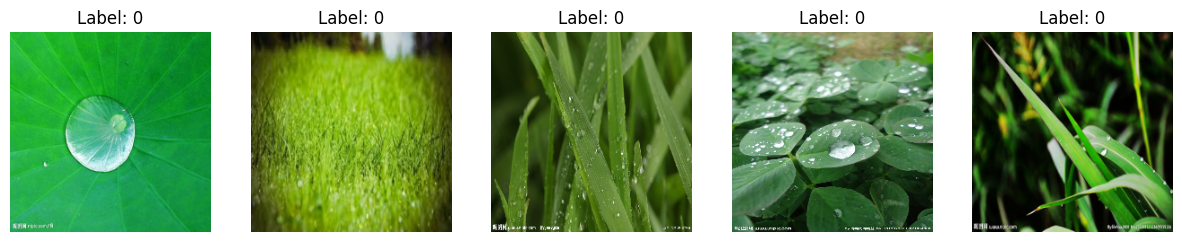

2025-04-13 00:53:57.813909: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-13 00:53:59.539341: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-13 00:54:01.638262: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-13 00:54:04.558486: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-13 00:54:06.169873: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-13 00:54:06.857264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:69: Filling up shuffle buffer (this may take a while): 838 of 1000
2025-04-13 00:54:08.555950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-04-13 00:54:08.934881: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-13 00:54:10.26973

In [9]:
# Load Data and Create Datasets
train_dataset, val_dataset = load_data()
X_train, y_train, X_val, y_val = create_datasets(train_dataset, val_dataset)

In [18]:
# Print the shape of the training dataset
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
# Print the shape of the validation dataset
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
# Print the shape of the first train sample
print(f"X_train[0] shape: {X_train[0].shape}")
print(f"y_train[0] shape: {y_train[0].shape}")

X_train shape: (10252, 224, 224, 3)
y_train shape: (10252, 1)
X_val shape: (1372, 224, 224, 3)
y_val shape: (1372, 1)
X_train[0] shape: (224, 224, 3)
y_train[0] shape: (1,)


## K-Means Color Quantization for 1st image in X_train
https://scikit-learn.org/0.19/auto_examples/cluster/plot_color_quantization.html

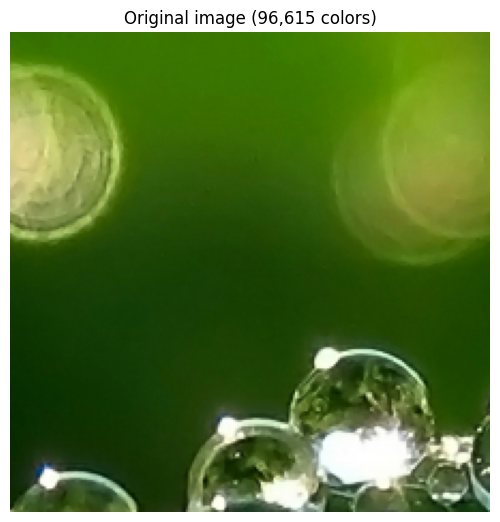

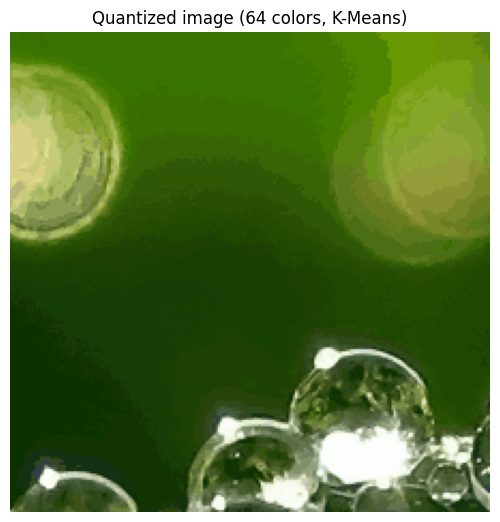

In [19]:
n_colors = 64

image_array = X_train[0].reshape(50176,3)
image_array_sample = shuffle(image_array, random_state=0)[:1000]

kmeans = KMeans(n_clusters=64, random_state=0).fit(image_array_sample)
labels = kmeans.predict(image_array)

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

# Display all results, alongside original image
plt.figure(1)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Original image (96,615 colors)')
plt.imshow(X_train[0])

plt.figure(2)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (64 colors, K-Means)')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, 224, 224))

## K-Means Color Quantization for All Images in X_train

In [26]:
n_colors = 64

X_train_quantized_kmeans = []
for i in range(len(X_train)):
    image_array = X_train[i].reshape(50176,3)
    image_array_sample = shuffle(image_array, random_state=0)[:1000]

    kmeans = KMeans(n_clusters=64, random_state=0).fit(image_array_sample)
    labels = kmeans.predict(image_array)

    def recreate_image(codebook, labels, w, h):
        """Recreate the (compressed) image from the code book & labels"""
        d = codebook.shape[1]
        image = np.zeros((w, h, d))
        label_idx = 0
        for i in range(w):
            for j in range(h):
                image[i][j] = codebook[labels[label_idx]]
                label_idx += 1
        return image
    
    quantized_image = recreate_image(kmeans.cluster_centers_, labels, 224, 224)
    X_train_quantized_kmeans.append(quantized_image)

X_train_quantized_kmeans = np.array(X_train_quantized_kmeans, dtype=np.float32)

/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


## Model Building

In [19]:
# Build Model with Accuracy, AUC, and F1-score metrics
def build_model(X_train, y_train, input_shape, epochs): # w/o pca is (224,224,3)

    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01)), 
        BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.3),
        
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)), 
        BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        BatchNormalization(),
        layers.Dropout(0.3),
        

        layers.Flatten(), # Flatten the output before the dense layer
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(11, activation='softmax')  
    ])
            
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print(model.summary())

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model_history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2)

    return model, model_history


def plot_history(model_history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(model_history.history['accuracy'], label='Train Accuracy')
    plt.plot(model_history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Training Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(model_history.history['loss'], label='Train Loss')
    plt.plot(model_history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Training Loss')

    plt.show()
    

def evaluate_model(model, X_val, y_val):
    results = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Loss: {results[0]}")
    print(f"Validation Accuracy: {results[1]}")

    # Get model predictions
    Y_val_pred = model.predict(x=X_val)
    # Get the class with the highest probability for each sample
    Y_val_pred_classes = np.argmax(Y_val_pred, axis=1)

    # Precision, Recall, and F1-Score
    precision = precision_score(y_val, Y_val_pred_classes, average='macro')  
    recall = recall_score(y_val, Y_val_pred_classes, average='macro')        
    f1 = f1_score(y_val, Y_val_pred_classes, average='macro')               

    # AUC (One-vs-Rest for multiclass)
    # Convert y_val to one-hot encoding if it's not already
    y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=11)  
    auc = roc_auc_score(y_val_one_hot, Y_val_pred, multi_class='ovr')   

    # Print the metrics
    print(f"Val Precision: {precision}")
    print(f"Val Recall: {recall}")
    print(f"Val F1-Score: {f1}")
    print(f"Val AUC (Avg): {auc}")

    # Print classification report for subgroup accuracies
    print(classification_report(y_val, Y_val_pred_classes, target_names=[str(label) for label in np.unique(y_val)]))
    
    # Get confusion matrix
    conf_matrix=confusion_matrix(y_val, Y_val_pred_classes)
    # Plot confusion matrix
    display = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(y_val))
    display.plot()
    plt.title("Validation Dataset Confusion Matrix")
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8, rotation=25)
    plt.show()


In [22]:
# Print the shape of the training dataset
print(f"X_train shape: {X_train_quantized_kmeans.shape}")
print(f"y_train shape: {y_train.shape}")
# Print the shape of the validation dataset
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
# Print the shape of the first train sample
print(f"X_train[0] shape: {X_train_quantized_kmeans[0].shape}")
print(f"y_train[0] shape: {y_train[0].shape}")

X_train shape: (10252, 224, 224, 3)
y_train shape: (10252, 1)
X_val shape: (1372, 224, 224, 3)
y_val shape: (1372, 1)
X_train[0] shape: (224, 224, 3)
y_train[0] shape: (1,)


/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 52, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 346112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    44,302,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,398,539 (169.37 MB)

 Trainable params: 44,397,835 (169.36 MB)

 Non-trainable params: 704 (2.75 KB)

None
Epoch 1/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 718s 3s/step - accuracy: 0.5455 - loss: 9.5912 - val_accuracy: 0.0317 - val_loss: 5.2193
Epoch 2/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 698s 3s/step - accuracy: 0.6476 - loss: 3.2016 - val_accuracy: 0.2594 - val_loss: 4.7698
Epoch 3/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 690s 3s/step - accuracy: 0.6663 - loss: 3.2668 - val_accuracy: 0.2716 - val_loss: 5.9887
Epoch 4/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 766s 3s/step - accuracy: 0.6752 - loss: 3.5433 - val_accuracy: 0.2711 - val_loss: 5.9047
Epoch 5/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 765s 3s/step - accuracy: 0.6902 - loss: 3.6466 - val_accuracy: 0.0244 - val_loss: 7.9812


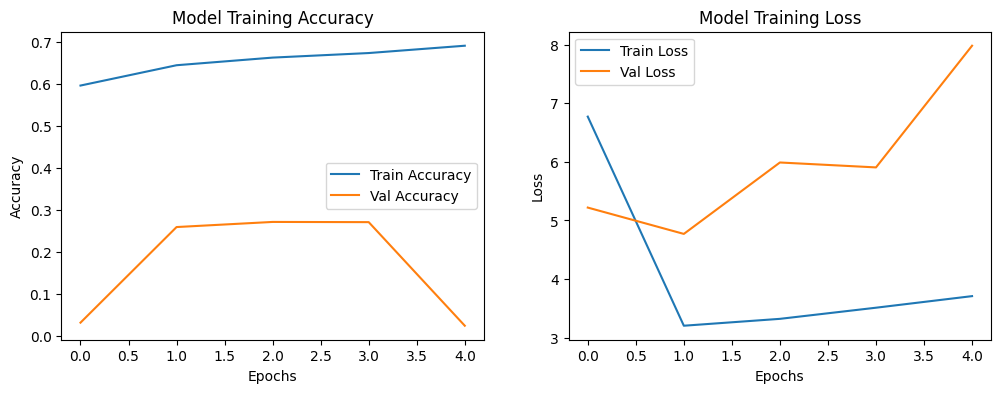

Validation Loss: 5.961714267730713
Validation Accuracy: 0.25
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 297ms/step
Val Precision: 0.39825142578107003
Val Recall: 0.26809039706388094
Val F1-Score: 0.1589251661050789
Val AUC (Avg): 0.7952976597992595
              precision    recall  f1-score   support

           0       0.51      0.80      0.63       139
           1       1.00      0.12      0.21       173
           2       0.67      0.02      0.04        96
           3       1.00      0.02      0.03       125
           4       0.27      0.07      0.11       106
           5       0.28      0.96      0.44        81
           6       0.15      0.95      0.25       129
           7       0.50      0.02      0.04        43
           8       0.00      0.00      0.00       228
           9       0.00      0.00      0.00       143
          10       0.00      0.00      0.00       109

    accuracy                           0.25      1372
   macro avg       0.40      0.27      0.16      1372
weigh

/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

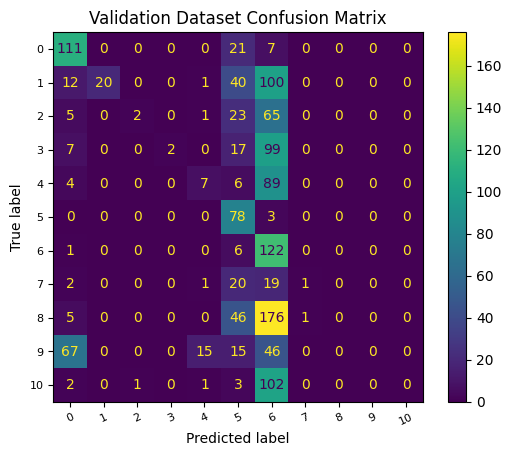

In [33]:
X_train_quantized_kmeans = tf.convert_to_tensor(X_train_quantized_kmeans, dtype=tf.float32)

kmeans_model, kmeans_model_history = build_model(X_train_quantized_kmeans, y_train, (224,224,3), epochs=5)

plot_history(kmeans_model_history)

evaluate_model(kmeans_model, X_val, y_val)

In [26]:
results = kmeans_model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {results[0]}")
print(f"Validation Accuracy: {results[1]}")

Validation Loss: 4.845664024353027
Validation Accuracy: 0.47303205728530884


## PCA on X_train

In [29]:
def pca(X_train_flat, X_val):
    # Create instance of PCA and fit
    pca = PCA()
    pca.fit_transform(X_train_flat)

    # Find cumulative variance
    var_cum = np.cumsum(pca.explained_variance_ratio_) * 100

    # How many principal components explain 95% of the variance?
    k = np.argmax(var_cum > 95) + 1  # +1 because np.argmax returns the first index where condition is met
    print("Number of principal components explaining 95% of variance: " + str(k))

    # Plot cumulative variance
    plt.figure(figsize=[5, 4])
    plt.title('Cumulative variance explained by the components')
    plt.ylabel('Explained variance')
    plt.xlabel('Principal components')
    plt.axvline(x=k, color="k", linestyle="--", label=f"K={k}")
    plt.axhline(y=95, color="r", linestyle="--", label="95% of cumulative variance")
    plt.plot(var_cum)
    plt.legend()
    plt.show()


def pca_fit(X_train_flat, X_val_flat, n_components, image_shape):
    # re run PCA using chosen k
    pca = PCA(n_components=n_components) 
    X_train_pca = pca.fit_transform(X_train_flat)
    X_val_pca = pca.transform(X_val_flat)

    # Get principal components
    principal_Df = pd.DataFrame(data = X_train_pca,)
    principal_Df['Label'] = y_train
    print(principal_Df.head())

    # Variance of principal components
    print('Explained Variation per Principal Component: {}'.format(pca.explained_variance_ratio_))

    print(f"Before PCA X_train.shape: {X_train_flat.shape}")
    print(f"After PCA X_train.shape: {X_train_pca.shape}")

    # Reshape images to image_shape
    img_rows, img_cols= image_shape

    X_train_pca = X_train_pca.reshape(X_train_pca.shape[0], img_rows, img_cols, 3) 
    X_val_pca = X_val_pca.reshape(X_val.shape[0], img_rows, img_cols, 3) 

    print(f"After PCA X_train reshaped: {X_train_pca.shape}")
    print(f"y_train: {y_train.shape}")

    return pca, X_train_pca, X_val_pca

Number of principal components explaining 95% of variance: 1105


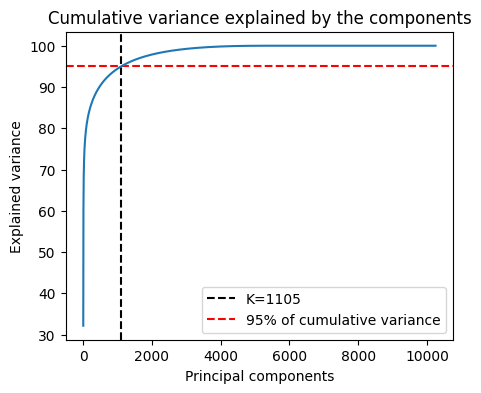

In [11]:
# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)  
X_val_flat = X_val.reshape(X_val.shape[0], -1)  

pca(X_train_flat, X_val_flat)

In [23]:
# re run PCA using chosen k = 1200 for compatability with vgg16 (20 x 20 = 400 * 3 = 1200)
pca, X_train_pca, X_val_pca = pca_fit(X_train_flat, X_val_flat, n_components=1200, image_shape = (20, 20))

           0          1          2          3          4          5  \
0 -16.485088 -29.604931 -16.849474  15.330660 -17.723198  17.918911   
1   4.367958  53.951782  -9.713175  -8.009430 -20.049467  12.225202   
2 -60.084515  18.962496 -16.455286  -5.321959   0.095991   2.302872   
3   7.336504 -37.215244 -17.020939  11.937793 -27.319466 -11.407098   
4   6.760394  16.851028  -9.210596  -2.120875  -0.759835   6.005490   

           6          7          8          9  ...      1074      1075  \
0   4.912817 -17.417004 -30.134966 -18.325819  ... -1.520387 -0.844390   
1  34.885681  -9.604683 -31.097553   1.880418  ...  0.162828 -0.388221   
2  16.324266  -9.304006 -15.031070 -16.519501  ...  0.127995 -0.367055   
3 -17.405771  38.532360 -12.923971   1.652072  ... -0.665857  1.304839   
4  23.664034  18.108130  11.808695  -9.449619  ...  0.340982 -0.141752   

       1076      1077      1078      1079      1080      1081      1082  Label  
0 -0.835087 -0.828646  0.964493  0.969187  0.78

/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 17, 17, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 17, 17, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 6, 6, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 6, 6, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 1, 1, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,587 (439.79 KB)

 Trainable params: 111,883 (437.04 KB)

 Non-trainable params: 704 (2.75 KB)

None
Epoch 1/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.2907 - loss: 4.7324 - val_accuracy: 0.2072 - val_loss: 4.6864
Epoch 2/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4236 - loss: 3.2626 - val_accuracy: 0.2023 - val_loss: 4.2501
Epoch 3/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4703 - loss: 2.5363 - val_accuracy: 0.2462 - val_loss: 3.9464
Epoch 4/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5125 - loss: 2.1115 - val_accuracy: 0.2462 - val_loss: 3.9609
Epoch 5/5
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5259 - loss: 1.8572 - val_accuracy: 0.2765 - val_loss: 3.9820


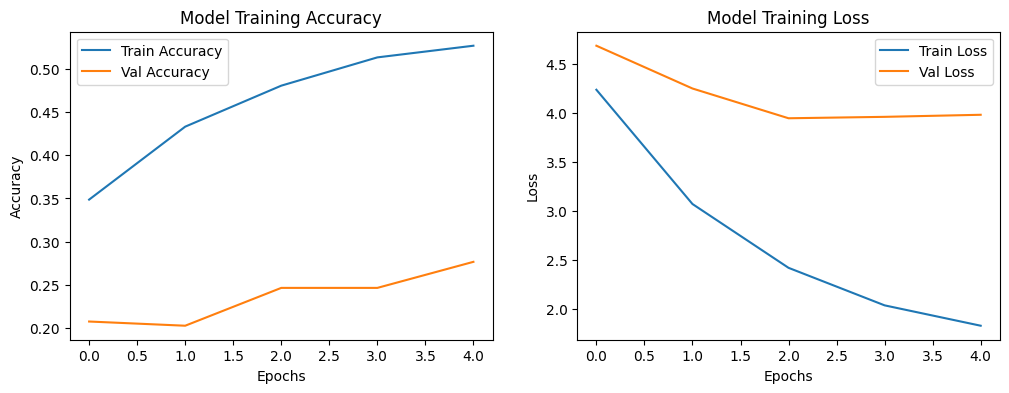

Validation Loss: 2.049513339996338
Validation Accuracy: 0.5430029034614563
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Val Precision: 0.5196113363476296
Val Recall: 0.5008689079656929
Val F1-Score: 0.46599808143274757
Val AUC (Avg): 0.8726677868469799
              precision    recall  f1-score   support

           0       0.82      0.77      0.80       139
           1       0.62      0.87      0.73       173
           2       0.80      0.04      0.08        96
           3       0.38      0.41      0.39       125
           4       0.41      0.50      0.45       106
           5       0.55      0.81      0.66        81
           6       0.47      0.44      0.46       129
           7       0.26      0.42      0.32        43
           8       0.48      0.71      0.57       228
           9       0.92      0.53      0.67       143
          10       0.00      0.00      0.00       109

    accuracy                           0.54      1372
   macro avg       0.52      0.50      0.47      

/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

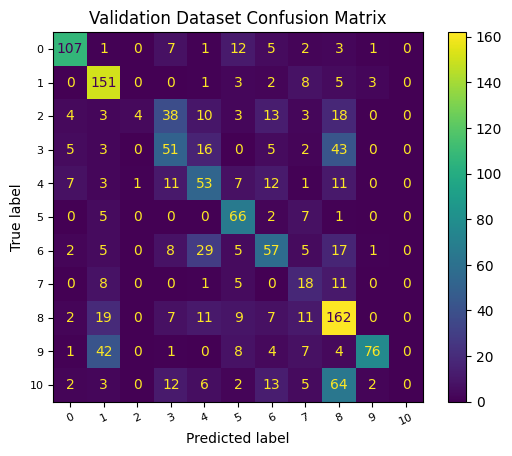

In [ ]:
# Build Model with X_train_pca 
pca_model, pca_model_history = build_model(X_train_pca, y_train, (20,20,3), epochs=5)
plot_history(pca_model_history)
evaluate_model(pca_model, X_val_pca, y_val)

## Stacking The 2 Models by Combining their Predictions

In [45]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, log_loss
from sklearn.linear_model import LogisticRegression

# Generate predictions on the transformed training sets
kmeans_preds = kmeans_model.predict(X_train_quantized_kmeans)  
pca_preds = pca_model.predict(X_train_pca)       

# Combine predictions as input for the meta-model
stacked_features = np.hstack((kmeans_preds, pca_preds))  

# Train the meta-model with stacked predictions
meta_model = LogisticRegression()
meta_model_history = meta_model.fit(stacked_features, y_train)  

321/321 ━━━━━━━━━━━━━━━━━━━━ 113s 351ms/step
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Ensemble Logistic Regression

43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 297ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Val Accuracy: 0.60932944606414
Val Loss: 1.1360530808759015
Val Precision: 0.583298097894488
Val Recall: 0.5891539935391685
Val F1-Score: 0.5738380272198056
Val AUC (Avg): 0.7748917948116198
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       139
           1       0.75      0.73      0.74       173
           2       0.62      0.27      0.38        96
           3       0.56      0.34      0.43       125
           4       0.48      0.55      0.51       106
           5       0.61      0.83      0.70        81
           6       0.59      0.65      0.62       129
           7       0.35      0.53      0.42        43
           8       0.64      0.64      0.64       228
           9       0.69      0.78      0.73       143
          10       0.32      0.33      0.32       109

    accuracy                           0.61      1372
   macro avg       0.58 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

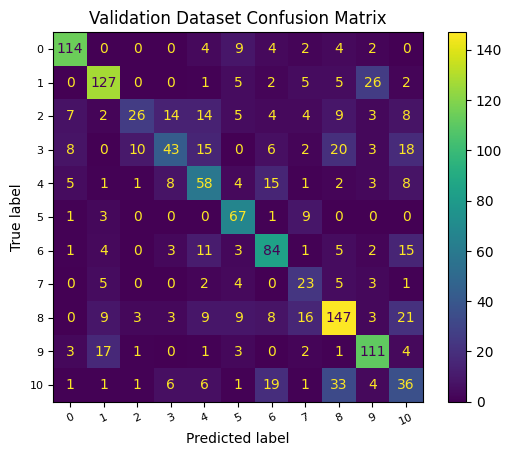

In [44]:
# Make val predictions
kmeans_preds = kmeans_model.predict(X_val)
pca_preds = pca_model.predict(X_val_pca)
stacked_val_features = np.hstack((kmeans_preds, pca_preds))
val_predictions = meta_model.predict(stacked_val_features)
val_probabilities = meta_model.predict_proba(stacked_val_features)

# Accuracy, Loss, Precision, Recall, and F1-Score
# Validation Accuracy
val_accuracy = accuracy_score(y_val, val_predictions)
val_loss = log_loss(y_val, val_probabilities)
val_precision = precision_score(y_val, val_predictions, average='macro')  
val_recall = recall_score(y_val, val_predictions, average='macro')       
val_f1 = f1_score(y_val, val_predictions, average='macro')                

# AUC (One-vs-Rest for multiclass)
# Convert y_val to one-hot encoding 
y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=11)  
val_predictions_one_hot = tf.keras.utils.to_categorical(val_predictions, num_classes=11)  
val_auc = roc_auc_score(y_val_one_hot, val_predictions_one_hot, multi_class='ovr')   

# Print the metrics
print(f"Val Accuracy: {val_accuracy}")
print(f"Val Loss: {val_loss}")
print(f"Val Precision: {val_precision}")
print(f"Val Recall: {val_recall}")
print(f"Val F1-Score: {val_f1}")
print(f"Val AUC (Avg): {val_auc}")

# Print classification report for subgroup accuracies
print(classification_report(y_val, val_predictions, target_names=[str(label) for label in np.unique(y_val)]))
    
# Get confusion matrix
conf_matrix=confusion_matrix(y_val, val_predictions)

# Plot confusion matrix
display = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(y_val))
display.plot()
plt.title("Validation Dataset Confusion Matrix")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8, rotation=25)

### Ensemble CNN

Epoch 1/100


/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3899 - loss: 1.8702 - val_accuracy: 0.6182 - val_loss: 1.1167
Epoch 2/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6065 - loss: 1.1776 - val_accuracy: 0.6314 - val_loss: 1.0405
Epoch 3/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6225 - loss: 1.1236 - val_accuracy: 0.6451 - val_loss: 1.0134
Epoch 4/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6332 - loss: 1.0889 - val_accuracy: 0.6582 - val_loss: 0.9911
Epoch 5/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6450 - loss: 1.0610 - val_accuracy: 0.6572 - val_loss: 0.9810
Epoch 6/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6387 - loss: 1.0600 - val_accuracy: 0.6577 - val_loss: 0.9658
Epoch 7/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6526 - loss: 1.0337 - val_accuracy: 0.6616 - val_loss: 0.9625
Epoch 8/100
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6491 - loss: 1.0311 - val_accuracy: 0.6699

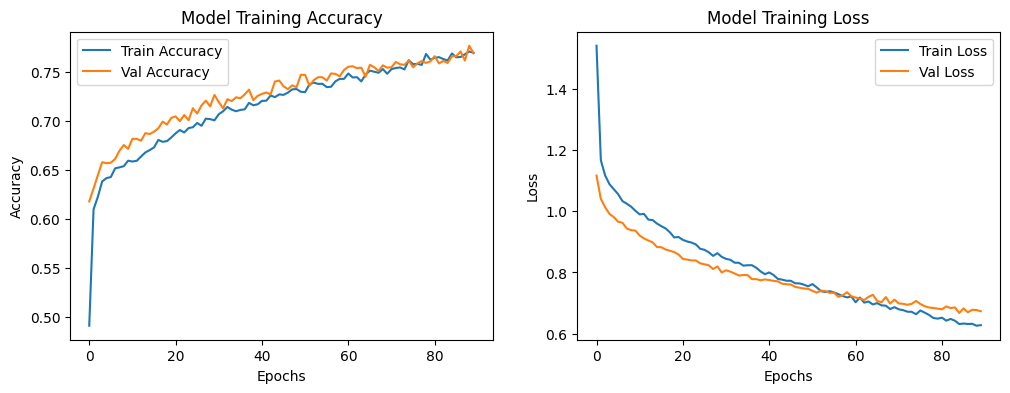

Validation Loss: 0.667319118976593
Validation Accuracy: 0.7664554119110107
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Val Precision: 0.7642385602883027
Val Recall: 0.7646718620093751
Val F1-Score: 0.7629503042514223
Val AUC (Avg): 0.9717588918908511
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       196
           1       0.79      0.85      0.82       207
           2       0.69      0.75      0.72       178
           3       0.68      0.64      0.66       203
           4       0.77      0.71      0.74       164
           5       0.91      0.96      0.93       186
           6       0.76      0.76      0.76       196
           7       0.89      0.96      0.92       170
           8       0.65      0.75      0.70       188
           9       0.85      0.77      0.81       192
          10       0.48      0.42      0.45       171

    accuracy                           0.77      2051
   macro avg       0.76      0.76      0.76      2

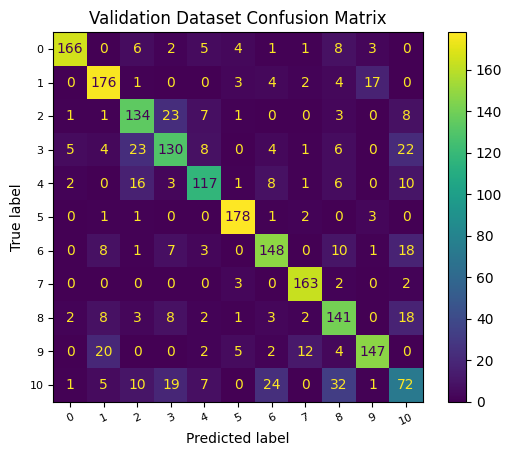

In [72]:
def build_meta_cnn(input_shape, num_classes):
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),  
        tf.keras.layers.Conv2D(32, (1, 3), activation='relu', padding='same'),  # Kernel size adjusted for small input
        tf.keras.layers.MaxPooling2D((1, 2)),
        tf.keras.layers.Conv2D(64, (1, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((1, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Reshape the input for CNN
stacked_features_reshaped = stacked_features.reshape(-1, 1, 22, 1)  # Shape: (10252, 1, 22, 1)

# Build the CNN model
meta_model_cnn = build_meta_cnn(input_shape=(1, 22, 1), num_classes=11)

# Manually split the data into training and validation sets to handle shape issues with validation_split=0.2
X_train, X_val, y_train_split, y_val_split = train_test_split(
    stacked_features_reshaped, y_train.flatten(), test_size=0.2, random_state=42
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with explicit validation data
meta_model_cnn_history = meta_model_cnn.fit(X_train, y_train_split, epochs=100, validation_data=(X_val, y_val_split), batch_size=32, callbacks=(early_stopping))

plot_history(meta_model_cnn_history)
evaluate_model(meta_model_cnn, X_val, y_val_split)